In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
from datetime import datetime, timedelta

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from tqdm import tqdm

# import aggregated data

In [5]:
df_all = pd.read_csv('data/data_pm25_plus_darksky.csv',index_col = 0, header = 0)
df_all.head()

,date,pm25_nie,pm25_kon,pm25_wok,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed,year,month,day,hour,day_of_week,no_of_week,winter_break
0,2015-01-01 00:00:00,51.5034,78.085,51.320000,32.93,1.0,29.56,0.87,NaN,NaN,0.0,0.0,0.0,NaN,1027.7,NaN,32.93,1.420067e+09,0.0,2.733,260.0,6.93,6.93,2015,1,1,0,4,1,0
1,2015-01-01 01:00:00,71.8204,78.085,68.982316,33.90,1.0,31.11,0.89,NaN,NaN,0.0,0.0,0.0,NaN,1027.7,NaN,33.90,1.420070e+09,0.0,2.733,260.0,6.93,6.93,2015,1,1,1,4,1,0
2,2015-01-01 02:00:00,42.6996,64.460,48.707108,27.73,1.0,31.59,0.91,cloudy,NaN,0.0,0.0,0.0,NaN,1027.7,Overcast,33.81,1.420074e+09,0.0,2.733,260.0,6.93,6.93,2015,1,1,2,4,1,0
3,2015-01-01 03:00:00,38.2824,36.210,37.986883,27.73,1.0,32.76,0.96,fog,NaN,0.0,0.0,0.0,NaN,1027.7,Foggy,33.81,1.420078e+09,0.0,1.244,251.0,6.93,6.93,2015,1,1,3,4,1,0
4,2015-01-01 04:00:00,35.4194,29.585,33.675489,26.41,1.0,32.89,0.97,fog,NaN,0.0,0.0,0.0,NaN,1027.7,Foggy,33.73,1.420081e+09,0.0,1.152,251.0,8.96,8.96,2015,1,1,4,4,1,0


In [6]:
df_all.columns

Index(['date', 'pm25_nie', 'pm25_kon', 'pm25_wok', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'ozone',
       'precipAccumulation', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'summary', 'temperature', 'time', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed', 'year', 'month',
       'day', 'hour', 'day_of_week', 'no_of_week', 'winter_break'],
      dtype='object')

# correlation

In [7]:
variables_corr = ['pm25_nie', 'pm25_kon', 'pm25_wok',
        'date', 'year', 'month', 'day','hour', 
        'day_of_week', 'no_of_week', 'winter_break',
        'apparentTemperature',
        'cloudCover', 'dewPoint', 'humidity', 
        'precipAccumulation', 'precipIntensity', 'precipProbability',
        'precipType', 'pressure', 'temperature', 'uvIndex',
        'visibility', 'windBearing', 'windGust', 'windSpeed']

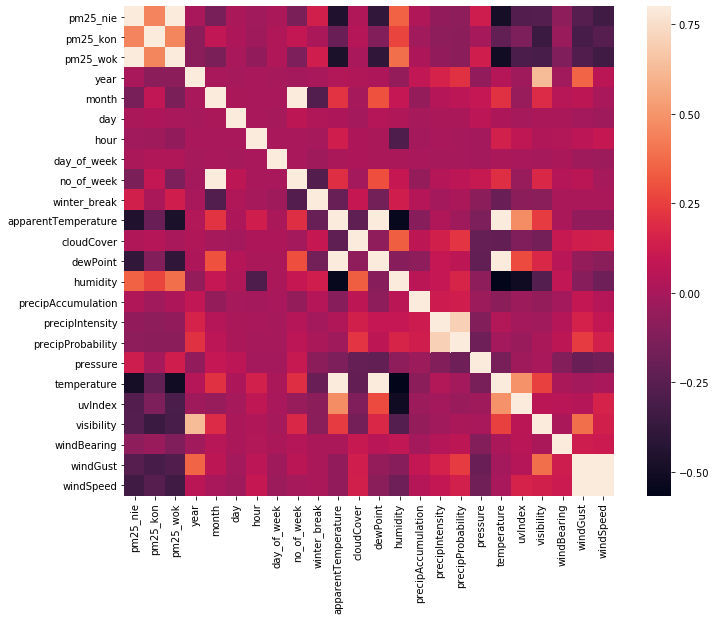

In [8]:
corrmat = df_all[variables_corr].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# VIF - variance inflation factor
which variables are the most correleted with other variables

In [9]:
df_cor = df_all[variables_corr].corr()

In [10]:
vifs = pd.Series(np.linalg.inv(df_cor.values).diagonal(), index=df_cor.index)

In [11]:
vifs.sort_values(ascending=False)

temperature            219.106036
apparentTemperature    125.666083
dewPoint                87.160973
humidity                32.393281
month                   22.729463
no_of_week              22.499852
pm25_wok                 8.274731
pm25_nie                 7.938301
windGust                 5.335601
windSpeed                5.257859
visibility               2.776910
year                     2.394984
precipProbability        2.184273
precipIntensity          1.993141
uvIndex                  1.613159
pm25_kon                 1.602117
cloudCover               1.306285
pressure                 1.269099
hour                     1.155689
winter_break             1.142295
day                      1.100532
windBearing              1.094673
precipAccumulation       1.059246
day_of_week              1.005792
dtype: float64

# PM2.5 distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DC37F6828>,
      dtype=object)

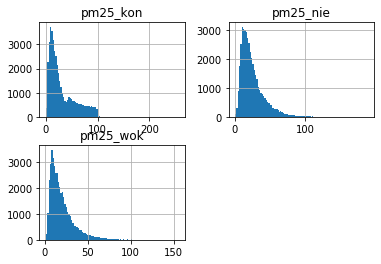

In [12]:
df_all[['pm25_nie','pm25_kon','pm25_wok']].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DC43E55F8>,
      dtype=object)

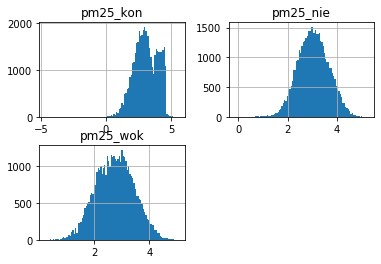

In [13]:
np.log(df_all[['pm25_nie','pm25_kon','pm25_wok']]).hist(bins = 100)

# models

In [14]:
from math import sqrt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split

In [15]:
feats = ['apparentTemperature',
        'cloudCover', 'dewPoint', 'humidity', 
        'precipAccumulation', 'precipIntensity', 'precipProbability',
        'pressure', 'temperature',  'uvIndex',
        'visibility', 'windBearing', 'windGust', 'windSpeed',
        'year', 'month', 'day','hour', 
        'day_of_week', 'no_of_week', 'winter_break']

In [37]:
#pollution = 'pm25_nie'
pollution = 'pm25_wok'

y = np.log(df_all[pollution])
X = df_all[feats].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 123)

In [39]:
n_folds = 5

def scoring_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    r2= cross_val_score(model, X_train, y_train, scoring="r2", cv = kf)
    return(rmse, r2)

## initial models

In [40]:
#XGBoost Regression
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 2020)

In [41]:
#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression', random_state = 2020)

In [42]:
#XGBoost Regression 

score = scoring_cv(model_xgb)
print("Xgboost rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Xgboost rmse: 0.3856 (0.0013), r2: 69.0%



In [43]:
#LightGBM 

score = scoring_cv(model_lgb)
print("LGBM rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

LGBM rmse: 0.3267 (0.0062), r2: 77.7%



# feature importance

In [23]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

Using TensorFlow backend.


In [44]:
model_xgb.fit(X, y)
model_lgb.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [45]:
perm = PermutationImportance(model_xgb).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feats, top=50)

Weight,Feature
0.1936 ± 0.0028,no_of_week
0.1625 ± 0.0028,windSpeed
0.1076 ± 0.0021,windBearing
0.0772 ± 0.0027,humidity
0.0730 ± 0.0027,visibility
0.0371 ± 0.0019,dewPoint
0.0371 ± 0.0010,year
0.0324 ± 0.0017,month
0.0309 ± 0.0010,temperature
0.0185 ± 0.0010,apparentTemperature


In [46]:
perm = PermutationImportance(model_lgb).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feats, top=50)

Weight,Feature
0.3122 ± 0.0015,no_of_week
0.1392 ± 0.0022,windSpeed
0.1308 ± 0.0020,windBearing
0.1167 ± 0.0025,visibility
0.0921 ± 0.0010,humidity
0.0832 ± 0.0019,dewPoint
0.0743 ± 0.0011,year
0.0574 ± 0.0012,month
0.0403 ± 0.0010,pressure
0.0257 ± 0.0010,temperature


# hyperopt
optimization of hyperparameters for xgboost model

In [47]:
def plot_xgb_learning_curve(train_evals, test_evals):
    mean_train_evals = np.mean(train_evals, axis=0)
    std_train_evals = np.std(train_evals, axis=0)

    mean_test_evals = np.mean(test_evals, axis=0)
    std_test_evals = np.std(test_evals, axis=0)

    plt.figure(figsize=(15, 5))

    plt.fill_between(range(len(mean_train_evals)), mean_train_evals - std_train_evals*30,
                     mean_train_evals + std_train_evals*30, alpha=0.1,
                     color="r")

    plt.fill_between(range(len(mean_test_evals)), mean_test_evals - std_test_evals*30,
                     mean_test_evals + std_test_evals*30, alpha=0.1,
                     color="g")


    plt.plot(mean_train_evals, label='train', c='r')
    plt.plot(mean_test_evals, label='test', c='g')
    plt.legend(loc='best')
    plt.title("Learning curve")
    plt.xlabel("# iterations")
    plt.ylabel("mae")
    plt.show()

def cv_xgb(df, feats, xgb_params, shift=1, folds=3, verbose=False, 
           early_stopping_rounds=5, plot_lc=True, return_model=False):
    X = df[ feats ].values
    y = df[ pollution ].values
    y_log = np.log( y + shift )
    
    cv = KFold(n_splits=3, shuffle=True, random_state=2020)

    scores = []
    train_evals, test_evals = [], []
    for train_idx, test_idx in tqdm( cv.split(X) ):

        model = xgb.XGBRegressor(**xgb_params)
        eval_set = [ (X[train_idx], y_log[train_idx]), (X[test_idx], y_log[test_idx]),  ]
        model.fit(X[train_idx], y_log[train_idx], eval_metric=eval_mae, eval_set=eval_set, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred_log = model.predict(X[test_idx])
        y_pred_log[ y_pred_log < 0 ] = 1e-6
        y_pred = np.exp( y_pred_log ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        
        evals_result = model.evals_result()

        if plot_lc:
            train_evals.append( evals_result['validation_0']['mae'] )
            test_evals.append( evals_result['validation_1']['mae'] )

    if plot_lc:
        def norm_rows(rows):
            min_rows = min( [len(x) for x in rows])
            return [x[:min_rows] for x in rows]

        plot_xgb_learning_curve(norm_rows(train_evals), norm_rows(test_evals))
        
    if return_model:
        return model, np.mean(scores), np.std(scores)
    
    return np.mean(scores), np.std(scores)

In [48]:
shift = 1
def eval_mae(y_pred_log, dtrain):
    y      = np.exp(dtrain.get_label()) - shift
    y_pred = np.exp(y_pred_log) - shift
    
    return 'mae', mean_absolute_error(y,y_pred)

{'max_depth': 19, 'colsample_bytree': 0.9794443641680879, 'learning_rate': 0.13580878016704173, 'subsample': 0.714520705942003, 'seed': 2019, 'min_child_weight': 20, 'reg_alpha': 1.4147189695118094, 'reg_lambda': 0.73291845458471, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
  0%|                                   | 0/30 [00:00<?, ?trial/s, best loss=?]

0it [00:00, ?it/s]

1it [00:23, 23.68s/it]

2it [00:45, 23.13s/it]

3it [01:07, 22.73s/it]



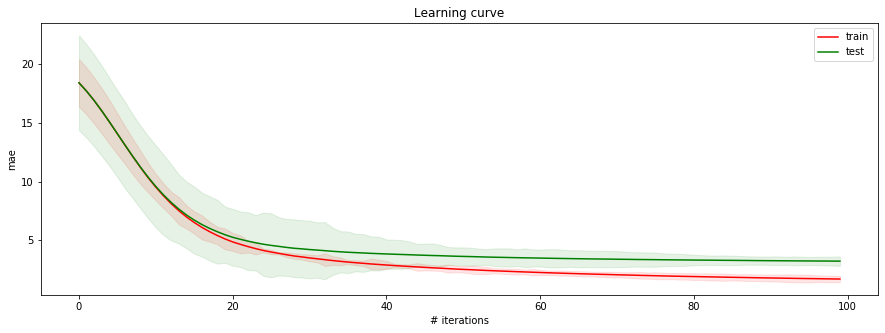

score:                                                                         
3.2215530585412773                                                             
0.013399087424376569                                                           
{'max_depth': 20, 'colsample_bytree': 0.9579306345463776, 'learning_rate': 0.13504664763062707, 'subsample': 0.6888806523033585, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 1.3040716971054496, 'reg_lambda': 0.7110731734724566, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
  3%|▎        | 1/30 [01:07<32:41, 67.65s/trial, best loss: 3.2215530585412773]

0it [00:00, ?it/s]

1it [00:24, 24.46s/it]

2it [00:48, 24.34s/it]

3it [01:12, 24.13s/it]



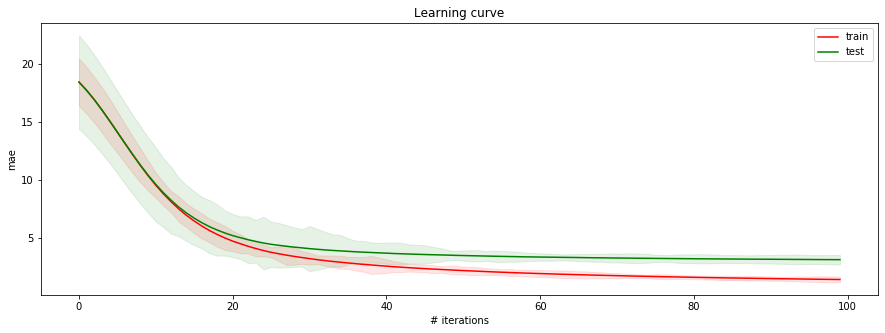

score:                                                                         
3.152112244766132                                                              
0.013544610829912167                                                           
{'max_depth': 20, 'colsample_bytree': 0.4192990681827563, 'learning_rate': 0.051980650804678244, 'subsample': 0.6043755075778228, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 1.0076750769116705, 'reg_lambda': 0.7010946836480964, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
  7%|▋         | 2/30 [02:20<32:14, 69.09s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:12, 12.07s/it]

2it [00:23, 11.99s/it]

3it [00:35, 11.94s/it]



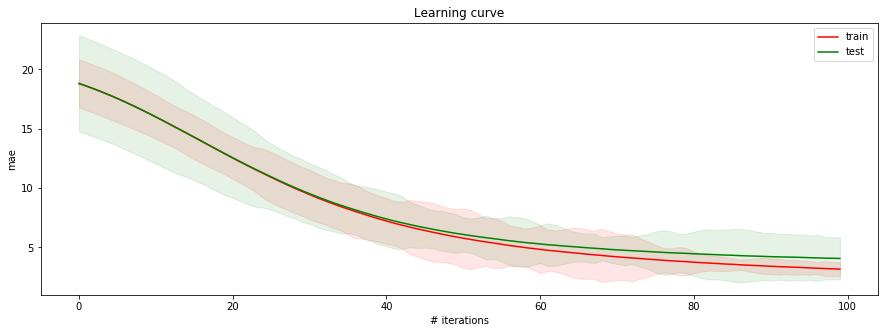

score:                                                                         
4.064342336679633                                                              
0.059119438046765435                                                           
{'max_depth': 8, 'colsample_bytree': 0.9921195723613541, 'learning_rate': 0.19005370012370143, 'subsample': 0.9985261781023825, 'seed': 2019, 'min_child_weight': 190, 'reg_alpha': 2.3039989705450035, 'reg_lambda': 0.962064868808558, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 10%|█         | 3/30 [02:56<26:37, 59.17s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:09,  9.67s/it]

2it [00:19,  9.77s/it]

3it [00:29,  9.82s/it]



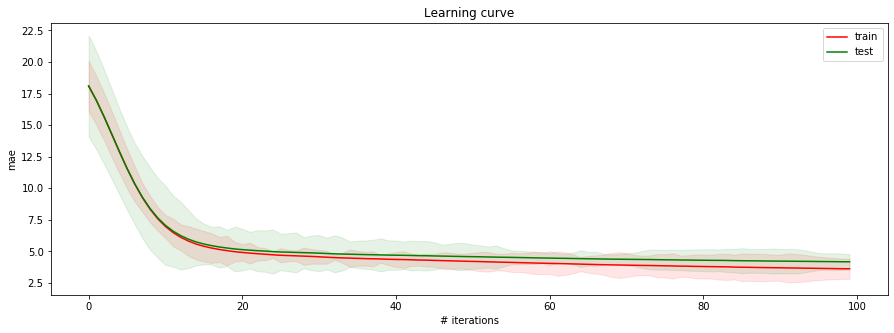

score:                                                                         
4.174926146894356                                                              
0.019887901385951822                                                           
{'max_depth': 14, 'colsample_bytree': 0.7030909244016132, 'learning_rate': 0.0745399896093372, 'subsample': 0.8867318186868021, 'seed': 2019, 'min_child_weight': 110, 'reg_alpha': 1.031408940911221, 'reg_lambda': 0.834214433293122, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 13%|█▎        | 4/30 [03:26<21:51, 50.44s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:12, 12.69s/it]

2it [00:25, 12.60s/it]

3it [00:37, 12.44s/it]



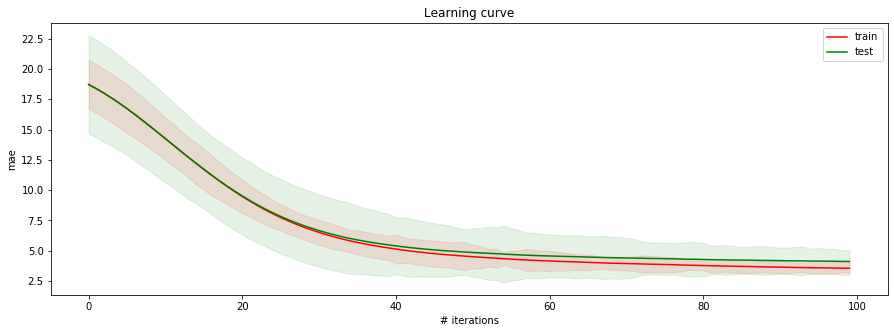

score:                                                                         
4.120596222998592                                                              
0.031008059079190218                                                           
{'max_depth': 15, 'colsample_bytree': 0.7164130652124744, 'learning_rate': 0.19548007887872265, 'subsample': 0.6234794443057935, 'seed': 2019, 'min_child_weight': 80, 'reg_alpha': 1.7638144566148966, 'reg_lambda': 0.8048611217001053, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 17%|█▋        | 5/30 [04:03<19:24, 46.57s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:14, 14.26s/it]

2it [00:27, 14.04s/it]

3it [00:42, 14.38s/it]



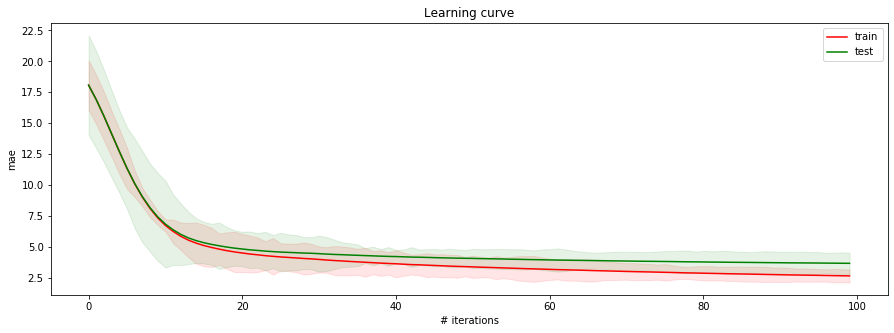

score:                                                                         
3.6932962005243244                                                             
0.02859759302186288                                                            
{'max_depth': 7, 'colsample_bytree': 0.2044618875814106, 'learning_rate': 0.12993621768843988, 'subsample': 0.7971183104568824, 'seed': 2019, 'min_child_weight': 70, 'reg_alpha': 1.3933833589897204, 'reg_lambda': 0.9731643525966822, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 20%|██        | 6/30 [04:47<18:14, 45.59s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:05,  5.62s/it]

2it [00:11,  5.64s/it]

3it [00:16,  5.56s/it]



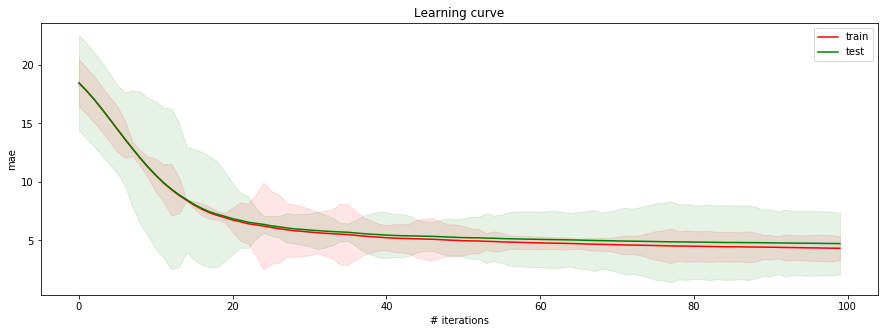

score:                                                                         
4.734081880288112                                                              
0.08825532025803519                                                            
{'max_depth': 17, 'colsample_bytree': 0.8951258159599268, 'learning_rate': 0.09026038735130762, 'subsample': 0.715699595281114, 'seed': 2019, 'min_child_weight': 150, 'reg_alpha': 2.628748826307252, 'reg_lambda': 0.7555086688860968, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 23%|██▎       | 7/30 [05:04<14:11, 37.01s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:13, 13.93s/it]

2it [00:27, 13.92s/it]

3it [00:42, 14.10s/it]



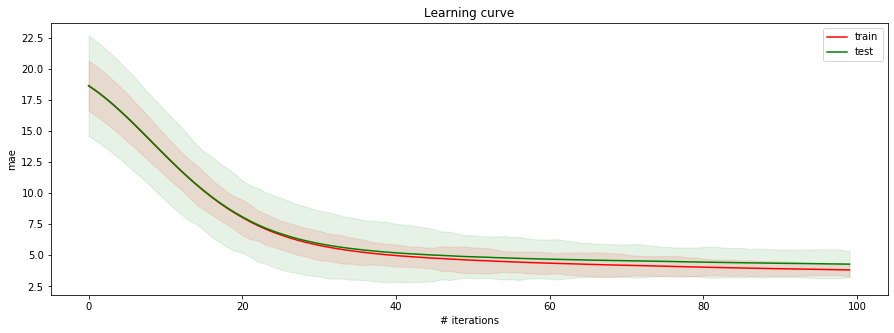

score:                                                                         
4.283715020887943                                                              
0.03539279566467967                                                            
{'max_depth': 11, 'colsample_bytree': 0.47564994682019646, 'learning_rate': 0.16128794684518338, 'subsample': 0.9178565005912168, 'seed': 2019, 'min_child_weight': 40, 'reg_alpha': 1.9051101605154002, 'reg_lambda': 0.9009342692867697, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 27%|██▋       | 8/30 [05:46<14:11, 38.71s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:09,  9.45s/it]

2it [00:18,  9.39s/it]

3it [00:28,  9.37s/it]



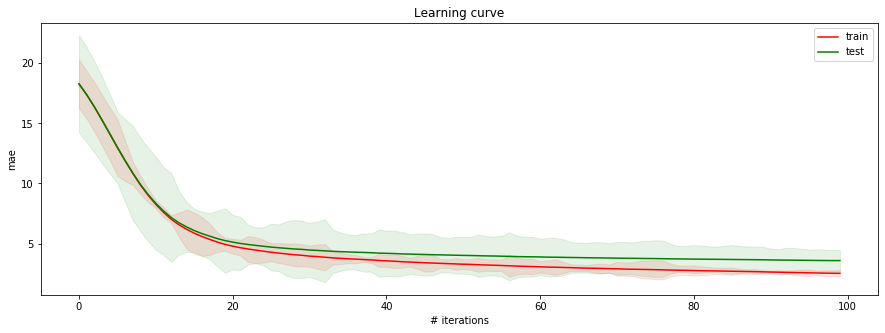

score:                                                                         
3.5919154361288967                                                             
0.02911117578396268                                                            
{'max_depth': 11, 'colsample_bytree': 0.8183641300097741, 'learning_rate': 0.10465298690962582, 'subsample': 0.6931101875905739, 'seed': 2019, 'min_child_weight': 120, 'reg_alpha': 1.267736664017913, 'reg_lambda': 0.8966795555849383, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 30%|███       | 9/30 [06:15<12:27, 35.60s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:11, 11.84s/it]

2it [00:23, 11.78s/it]

3it [00:36, 12.07s/it]



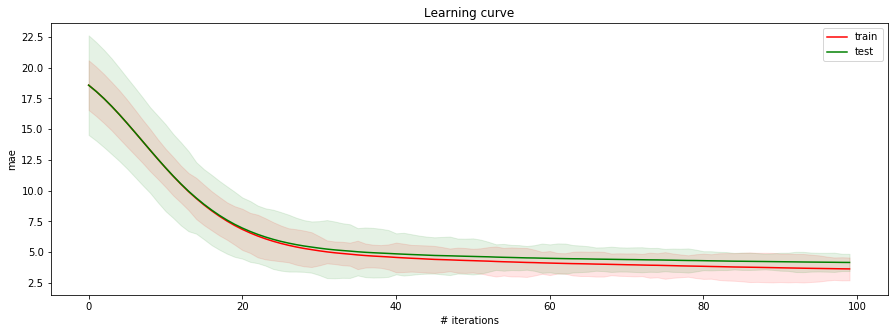

score:                                                                         
4.170006392454923                                                              
0.023309836666812335                                                           
{'max_depth': 18, 'colsample_bytree': 0.2634310798435292, 'learning_rate': 0.16228293565766772, 'subsample': 0.8170268363975368, 'seed': 2019, 'min_child_weight': 180, 'reg_alpha': 1.169619610933601, 'reg_lambda': 0.7779684820305566, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 33%|███      | 10/30 [06:51<11:57, 35.90s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:07,  7.69s/it]

2it [00:15,  7.68s/it]

3it [00:23,  7.69s/it]



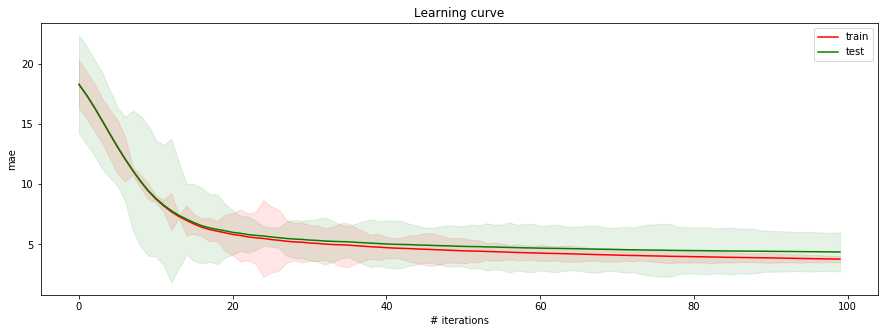

score:                                                                         
4.369534549985029                                                              
0.05381208097521341                                                            
{'max_depth': 16, 'colsample_bytree': 0.5853555316063852, 'learning_rate': 0.161625759551029, 'subsample': 0.790692361886737, 'seed': 2019, 'min_child_weight': 50, 'reg_alpha': 2.0173709049071724, 'reg_lambda': 0.7220757803590786, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 37%|███▎     | 11/30 [07:15<10:10, 32.14s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:13, 13.19s/it]

2it [00:26, 13.20s/it]

3it [00:40, 13.40s/it]



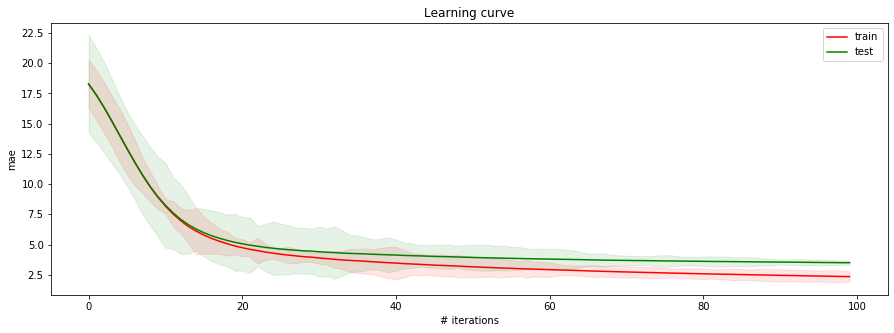

score:                                                                         
3.492842512300584                                                              
0.00541108445152042                                                            
{'max_depth': 5, 'colsample_bytree': 0.8219748827656093, 'learning_rate': 0.05650725654100448, 'subsample': 0.9867588499022739, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 1.5015058162243966, 'reg_lambda': 0.8720755965845667, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 40%|███▌     | 12/30 [07:55<10:24, 34.71s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:07,  7.02s/it]

2it [00:13,  7.01s/it]

3it [00:21,  7.04s/it]



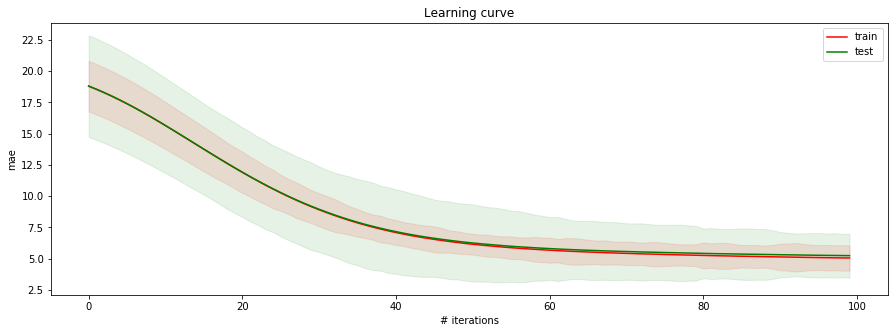

score:                                                                         
5.2344702506753675                                                             
0.058761900262524425                                                           
{'max_depth': 13, 'colsample_bytree': 0.3837456283417311, 'learning_rate': 0.10954814239876264, 'subsample': 0.6620889189175095, 'seed': 2019, 'min_child_weight': 140, 'reg_alpha': 2.683202229057574, 'reg_lambda': 0.7004801699738701, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 43%|███▉     | 13/30 [08:17<08:42, 30.73s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:08,  8.77s/it]

2it [00:17,  8.70s/it]

3it [00:26,  8.72s/it]



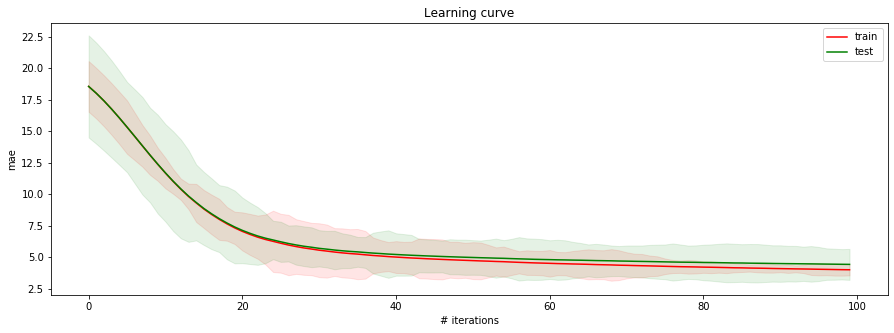

score:                                                                         
4.427575550274663                                                              
0.040971359574233875                                                           
{'max_depth': 20, 'colsample_bytree': 0.6334944287585235, 'learning_rate': 0.1446690713302317, 'subsample': 0.8689060753589859, 'seed': 2019, 'min_child_weight': 80, 'reg_alpha': 1.1153228413238105, 'reg_lambda': 0.9344876677380072, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 47%|████▏    | 14/30 [08:43<07:50, 29.43s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:14, 14.53s/it]

2it [00:31, 15.19s/it]

3it [00:51, 16.63s/it]



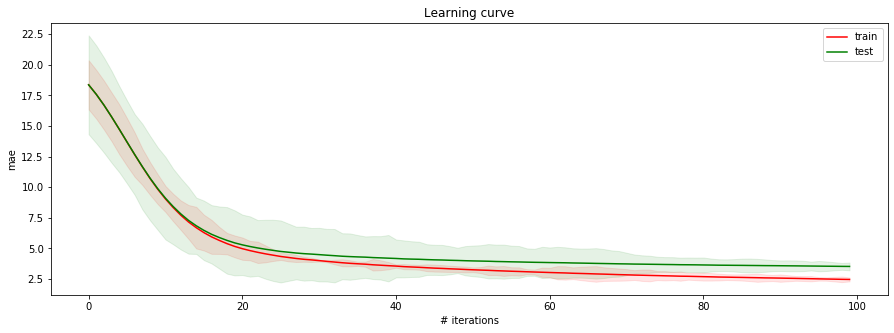

score:                                                                         
3.522200670578646                                                              
0.010549738494189009                                                           
{'max_depth': 11, 'colsample_bytree': 0.8978277131328747, 'learning_rate': 0.07749890316672683, 'subsample': 0.7647327355991944, 'seed': 2019, 'min_child_weight': 30, 'reg_alpha': 1.5929411725090423, 'reg_lambda': 0.8104204454579732, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 50%|████▌    | 15/30 [09:35<09:01, 36.08s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:15, 15.38s/it]

2it [00:33, 16.23s/it]

3it [00:49, 16.25s/it]



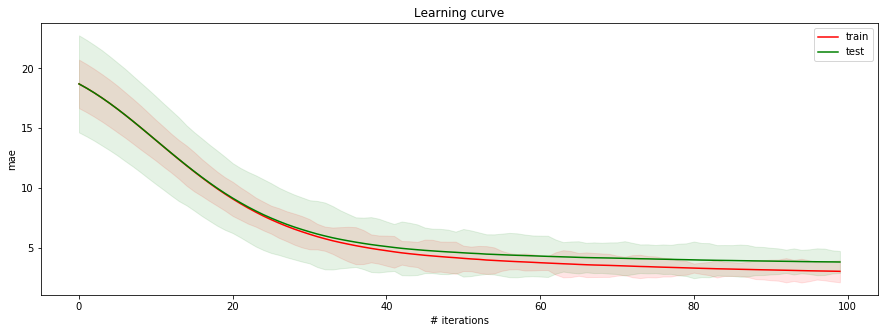

score:                                                                         
3.8372979810029055                                                             
0.030592492744897712                                                           
{'max_depth': 9, 'colsample_bytree': 0.5197229720812624, 'learning_rate': 0.17699222681238763, 'subsample': 0.9381437571820589, 'seed': 2019, 'min_child_weight': 60, 'reg_alpha': 2.2452751695565416, 'reg_lambda': 0.9995978921842036, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 53%|████▊    | 16/30 [10:25<09:25, 40.41s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:10, 10.01s/it]

2it [00:20, 10.19s/it]

3it [00:30, 10.05s/it]



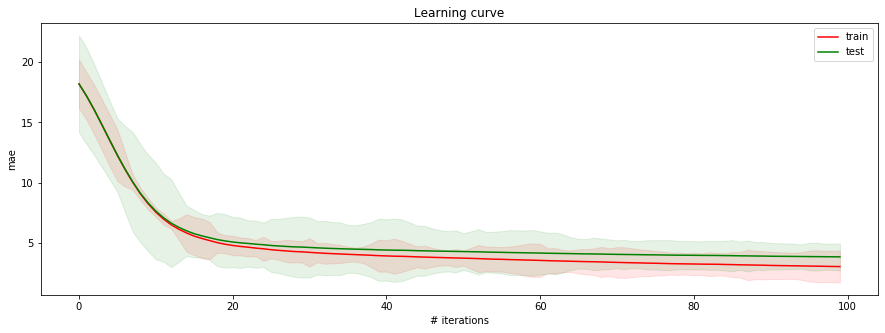

score:                                                                         
3.8330431353949046                                                             
0.03701200169862189                                                            
{'max_depth': 19, 'colsample_bytree': 0.9578214459421762, 'learning_rate': 0.13245337099800247, 'subsample': 0.7416166115938003, 'seed': 2019, 'min_child_weight': 20, 'reg_alpha': 1.3179821960752458, 'reg_lambda': 0.74113428528105, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 57%|█████    | 17/30 [10:56<08:07, 37.53s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:27, 27.18s/it]

2it [00:54, 27.18s/it]

3it [01:21, 27.12s/it]



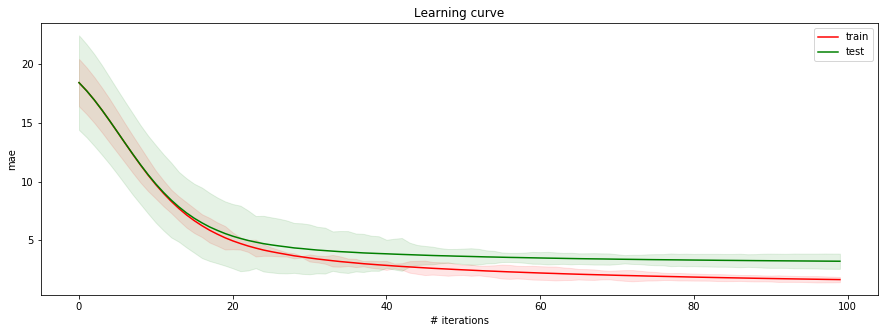

score:                                                                         
3.203284370243562                                                              
0.02165293450449308                                                            
{'max_depth': 18, 'colsample_bytree': 0.9773730045124351, 'learning_rate': 0.11865283088890545, 'subsample': 0.7457829638514952, 'seed': 2019, 'min_child_weight': 30, 'reg_alpha': 1.2774130614240296, 'reg_lambda': 0.7642075092051884, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 60%|█████▍   | 18/30 [12:18<10:09, 50.83s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:24, 24.66s/it]

2it [00:51, 25.18s/it]

3it [01:18, 25.83s/it]



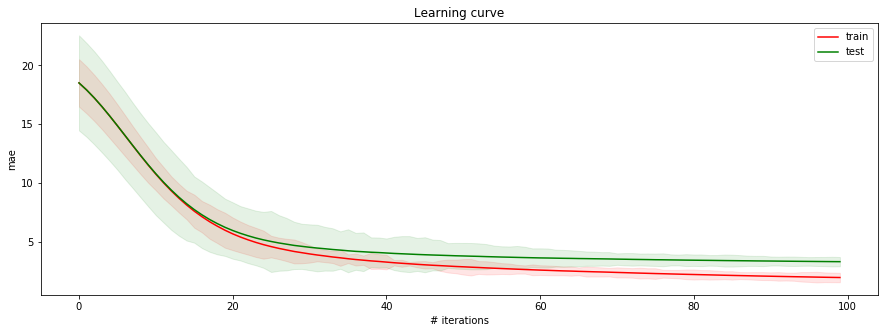

score:                                                                         
3.2914145395523864                                                             
0.013192280390135463                                                           
{'max_depth': 20, 'colsample_bytree': 0.8839822872756501, 'learning_rate': 0.14641752836382302, 'subsample': 0.6484103434094178, 'seed': 2019, 'min_child_weight': 90, 'reg_alpha': 1.2054063079269786, 'reg_lambda': 0.7316053750424218, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 63%|█████▋   | 19/30 [13:37<10:51, 59.22s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:21, 21.07s/it]

2it [00:43, 21.42s/it]

3it [01:03, 21.09s/it]



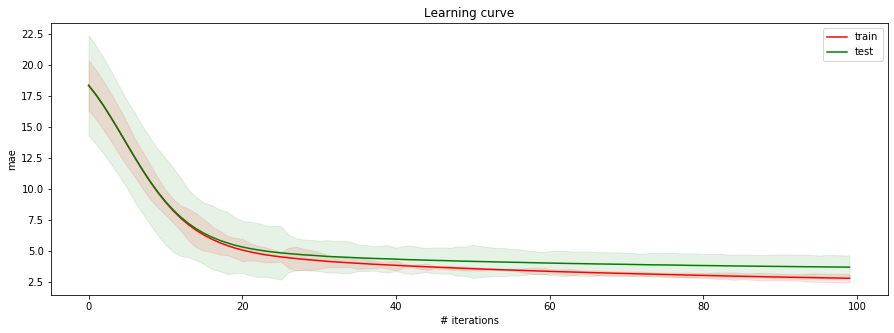

score:                                                                         
3.699391666540673                                                              
0.031337963584087435                                                           
{'max_depth': 16, 'colsample_bytree': 0.7665144723639709, 'learning_rate': 0.11806167201806661, 'subsample': 0.8393869319679786, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 1.3439374753139244, 'reg_lambda': 0.7868700670189386, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 67%|██████   | 20/30 [14:41<10:06, 60.66s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:18, 18.96s/it]

2it [00:37, 18.87s/it]

3it [00:56, 18.83s/it]



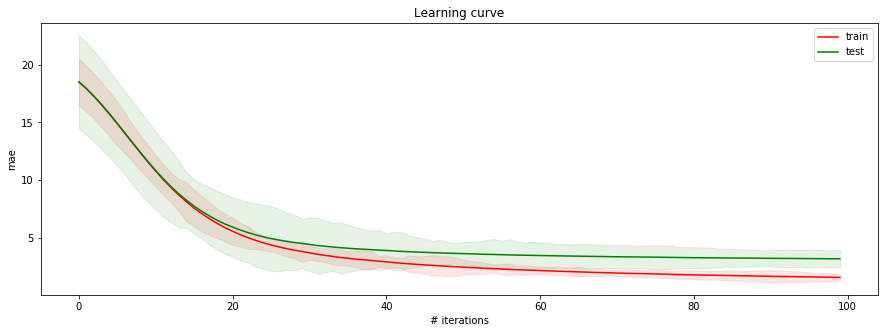

score:                                                                         
3.1886926081588025                                                             
0.025504928578875707                                                           
{'max_depth': 16, 'colsample_bytree': 0.7843036114129085, 'learning_rate': 0.09532042754791806, 'subsample': 0.843367541969775, 'seed': 2019, 'min_child_weight': 50, 'reg_alpha': 1.6748983501151402, 'reg_lambda': 0.791348594817766, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 70%|██████▎  | 21/30 [15:37<08:55, 59.48s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:17, 17.02s/it]

2it [00:33, 16.84s/it]

3it [00:53, 17.87s/it]



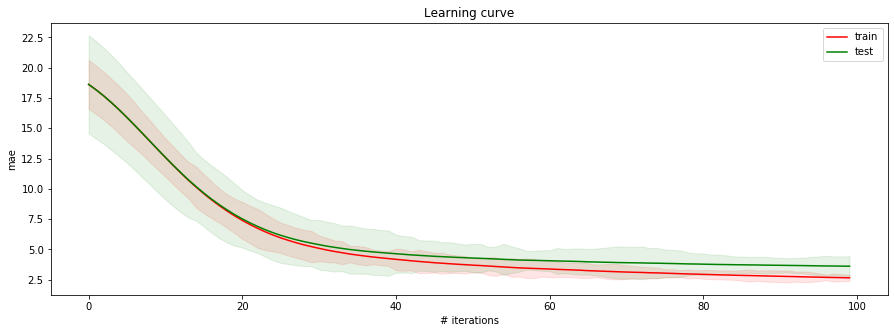

score:                                                                         
3.6081102336124253                                                             
0.02743340861739844                                                            
{'max_depth': 15, 'colsample_bytree': 0.7086237031237878, 'learning_rate': 0.11762586805152492, 'subsample': 0.8380329852153107, 'seed': 2019, 'min_child_weight': 40, 'reg_alpha': 1.0688923397689207, 'reg_lambda': 0.8202606458613164, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 73%|██████▌  | 22/30 [16:32<07:43, 57.88s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:19, 19.74s/it]

2it [00:37, 19.02s/it]

3it [00:54, 18.67s/it]



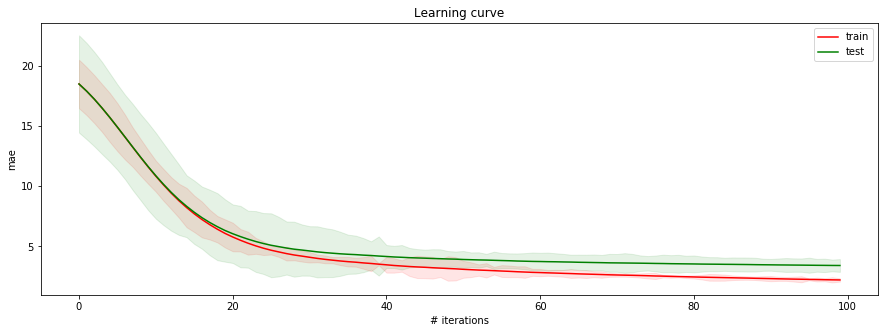

score:                                                                         
3.40617943387859                                                               
0.017721665439332908                                                           
{'max_depth': 17, 'colsample_bytree': 0.7702728134836877, 'learning_rate': 0.15069174250122358, 'subsample': 0.9483631120204639, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 1.4649426841255284, 'reg_lambda': 0.8504793408560537, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 77%|██████▉  | 23/30 [17:27<06:39, 57.11s/trial, best loss: 3.152112244766132]

0it [00:00, ?it/s]

1it [00:24, 24.06s/it]

2it [00:48, 24.08s/it]

3it [01:10, 23.54s/it]



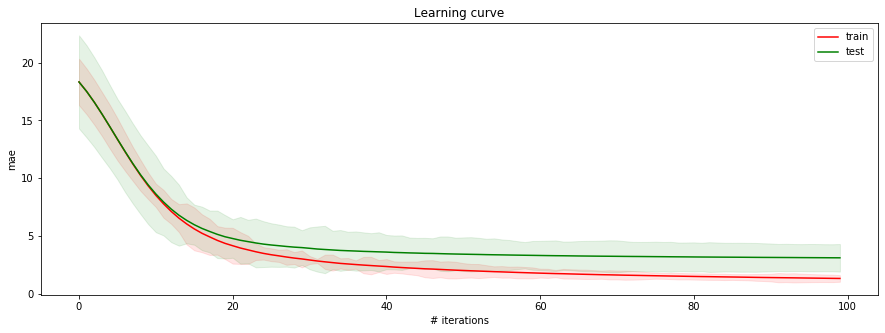

score:                                                                         
3.11351331560727                                                               
0.03979395347053575                                                            
{'max_depth': 18, 'colsample_bytree': 0.59377272574692, 'learning_rate': 0.1831008379259395, 'subsample': 0.9518308930413986, 'seed': 2019, 'min_child_weight': 100, 'reg_alpha': 1.5334651836293127, 'reg_lambda': 0.8595349035359507, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 80%|████████  | 24/30 [18:38<06:07, 61.23s/trial, best loss: 3.11351331560727]

0it [00:00, ?it/s]

1it [00:23, 23.85s/it]

2it [00:41, 21.96s/it]

3it [00:57, 20.11s/it]



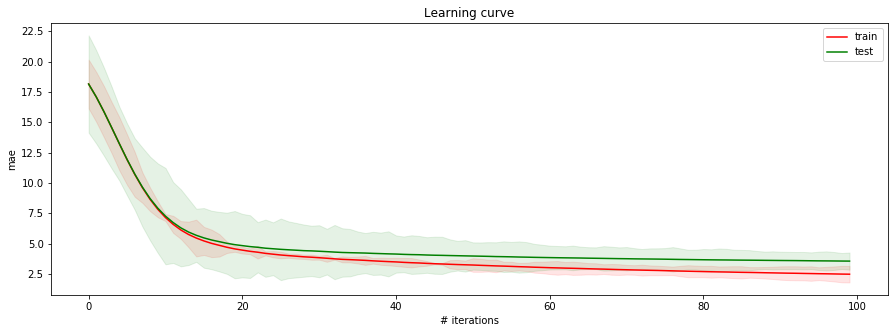

score:                                                                         
3.550052115718241                                                              
0.023642036532440788                                                           
{'max_depth': 13, 'colsample_bytree': 0.8683738768081604, 'learning_rate': 0.1486792125230186, 'subsample': 0.6713358328869825, 'seed': 2019, 'min_child_weight': 60, 'reg_alpha': 1.727138273350088, 'reg_lambda': 0.8870261580585194, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 83%|████████▎ | 25/30 [19:35<05:00, 60.13s/trial, best loss: 3.11351331560727]

0it [00:00, ?it/s]

1it [00:18, 18.45s/it]

2it [00:38, 18.99s/it]

3it [00:56, 18.62s/it]



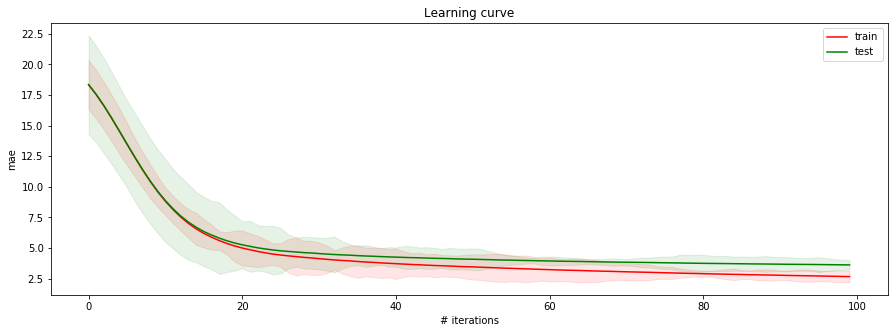

score:                                                                         
3.6281760800880654                                                             
0.01306353446193772                                                            
{'max_depth': 19, 'colsample_bytree': 0.6548225731236157, 'learning_rate': 0.17158780594079315, 'subsample': 0.974161451134626, 'seed': 2019, 'min_child_weight': 160, 'reg_alpha': 1.503260382309197, 'reg_lambda': 0.8429450848605592, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 87%|████████▋ | 26/30 [20:32<03:56, 59.16s/trial, best loss: 3.11351331560727]

0it [00:00, ?it/s]

1it [00:16, 16.40s/it]

2it [00:32, 16.24s/it]

3it [00:49, 16.55s/it]



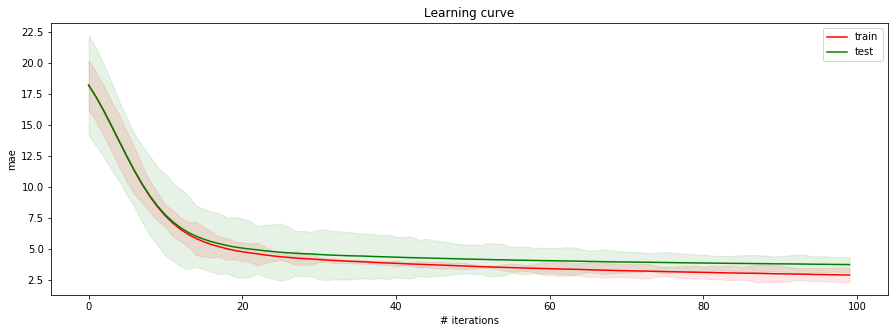

score:                                                                         
3.7572387708936765                                                             
0.020870216726091233                                                           
{'max_depth': 17, 'colsample_bytree': 0.9282321170128359, 'learning_rate': 0.15161618114931869, 'subsample': 0.8991726935097213, 'seed': 2019, 'min_child_weight': 130, 'reg_alpha': 1.8929378405847674, 'reg_lambda': 0.9155846571148457, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 90%|█████████ | 27/30 [21:22<02:49, 56.39s/trial, best loss: 3.11351331560727]

0it [00:00, ?it/s]

1it [00:20, 20.39s/it]

2it [00:39, 20.03s/it]

3it [01:00, 20.19s/it]



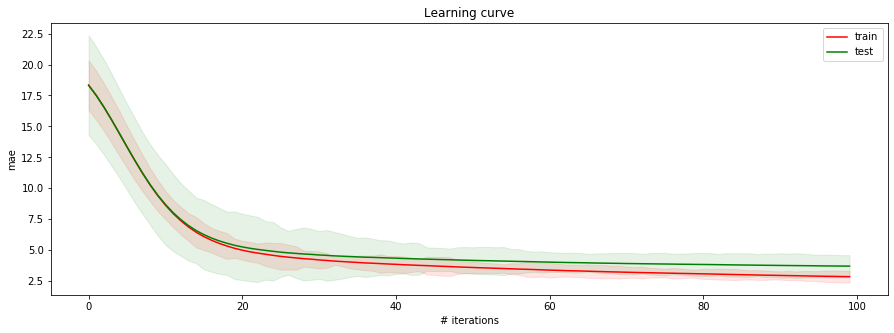

score:                                                                         
3.7077634644598945                                                             
0.029525976541927818                                                           
{'max_depth': 19, 'colsample_bytree': 0.8186811674719956, 'learning_rate': 0.13499633431925054, 'subsample': 0.7110549141581303, 'seed': 2019, 'min_child_weight': 20, 'reg_alpha': 1.445299069350734, 'reg_lambda': 0.8609391949573051, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 93%|█████████▎| 28/30 [22:23<01:55, 57.64s/trial, best loss: 3.11351331560727]

0it [00:00, ?it/s]

1it [00:24, 24.01s/it]

2it [00:47, 23.84s/it]

3it [01:11, 24.02s/it]



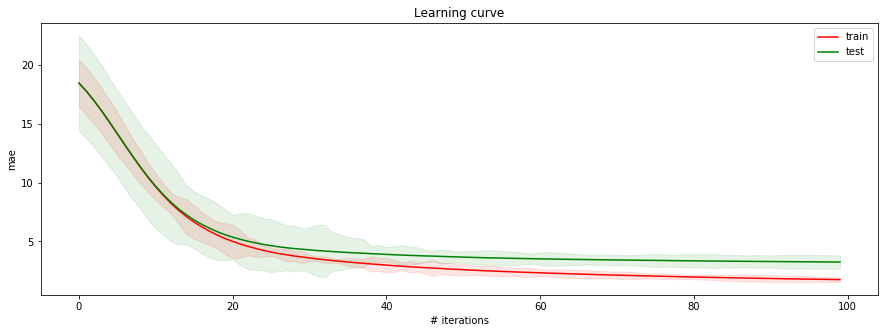

score:                                                                         
3.2592004001757453                                                             
0.018439984601697847                                                           
{'max_depth': 14, 'colsample_bytree': 0.7582342240507809, 'learning_rate': 0.16666571589728144, 'subsample': 0.6197037117946181, 'seed': 2019, 'min_child_weight': 30, 'reg_alpha': 1.1862227390095592, 'reg_lambda': 0.9229307258868582, 'n_estimators': 100, 'objective': 'reg:squarederror', 'random_state': 2020}
 97%|█████████▋| 29/30 [23:35<01:02, 62.03s/trial, best loss: 3.11351331560727]

0it [00:00, ?it/s]

1it [00:18, 18.39s/it]

2it [00:37, 18.70s/it]

3it [00:56, 18.68s/it]



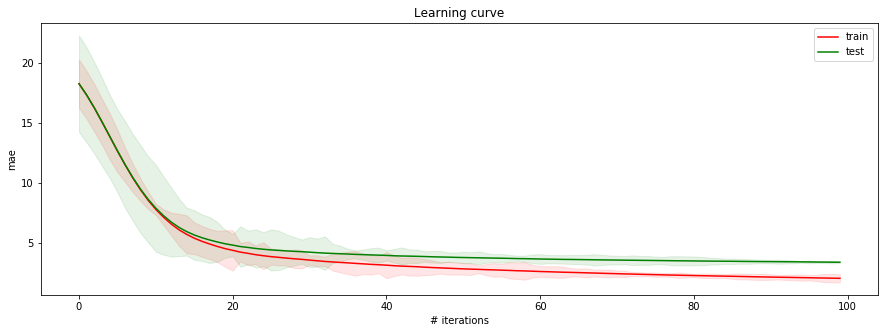

score:                                                                         
3.382457712627731                                                              
0.0018492200147555442                                                          
100%|██████████| 30/30 [24:32<00:00, 60.47s/trial, best loss: 3.11351331560727]
The best params:  {'x_colsample_bytree': 0.7702728134836877, 'x_learning_rate': 0.15069174250122358, 'x_max_depth': 17.0, 'x_min_child_weight': 10.0, 'x_reg_alpha': 1.4649426841255284, 'x_reg_lambda': 0.8504793408560537, 'x_seed': 5500.0, 'x_shift': 92.0, 'x_subsample': 0.9483631120204639}


In [49]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 2019, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'random_state': 2020,
    }
    
    print(xgb_params)
    
    #feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats
    mean_score, std_score = cv_xgb(df_all, feats, xgb_params, shift=1, plot_lc=True)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

In [50]:
trials.best_trial

{'state': 2,
 'tid': 23,
 'spec': None,
 'result': {'loss': 3.11351331560727, 'status': 'ok'},
 'misc': {'tid': 23,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [23],
   'x_learning_rate': [23],
   'x_max_depth': [23],
   'x_min_child_weight': [23],
   'x_reg_alpha': [23],
   'x_reg_lambda': [23],
   'x_seed': [23],
   'x_shift': [23],
   'x_subsample': [23]},
  'vals': {'x_colsample_bytree': [0.7702728134836877],
   'x_learning_rate': [0.15069174250122358],
   'x_max_depth': [17.0],
   'x_min_child_weight': [10.0],
   'x_reg_alpha': [1.4649426841255284],
   'x_reg_lambda': [0.8504793408560537],
   'x_seed': [5500.0],
   'x_shift': [92.0],
   'x_subsample': [0.9483631120204639]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 2, 18, 14, 51, 44, 382000),
 'refresh_time': datetime.datetime(2020, 2, 18, 14, 52, 55, 194000)}

## implementation pm25_nie

In [31]:
#XGBoost Regression
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 2020,
                            max_depth = 12, 
                            colsample_bytree = 0.5802889807808219, 
                            learning_rate = 0.1797884586071477,
                            subsample = 0.8643643831973243, 
                            seed = 2019, 
                            min_child_weight = 20, 
                            reg_alpha= 1.1716950782611402, 
                            reg_lambda= 0.7883591696635133, 
                            n_estimators = 100)

In [32]:
#XGBoost Regression 

score = scoring_cv(model_xgb)
print("Xgboost rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Xgboost rmse: 0.2820 (0.0048), r2: 79.9%



## implementation pm25_wok

In [51]:
#XGBoost Regression
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 2020,
                            max_depth = 18, 
                            colsample_bytree = 0.5937727257469, 
                            learning_rate = 0.1831008379259395,
                            subsample = 0.9518308930413986, 
                            seed = 2019, 
                            min_child_weight = 10, 
                            reg_alpha= 1.5334651836293127, 
                            reg_lambda= 0.8595349035359507, 
                            n_estimators = 100)

In [52]:
#XGBoost Regression 

score = scoring_cv(model_xgb)
print("Xgboost rmse: {:.4f} ({:.4f}), r2: {:.1f}%\n" .format(score[0].mean(), score[0].std(), 100*score[1].mean()))

Xgboost rmse: 0.2887 (0.0047), r2: 82.6%



# saving models

In [53]:
model_xgb.fit(X, y)
model_lgb.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [34]:
import joblib

In [36]:
joblib.dump(model_xgb, 'model/nie/model_xgb.pkl') 
joblib.dump(model_lgb, 'model/nie/model_lgb.pkl') 

['model/nie/model_lgb.pkl']

In [54]:
joblib.dump(model_xgb, 'model/wok/model_xgb.pkl') 
joblib.dump(model_lgb, 'model/wok/model_lgb.pkl') 

['model/wok/model_lgb.pkl']